# Reproduction code for the figure 1 of the supplementary information

In [3]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
import pickle
from tqdm import tqdm
import torch.autograd as autograd 
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs)

In [4]:
from functions.eqrdqn_functions import *

## Left

In [3]:
# The following dictionnary was created from the output files of the python scripts
# in the folder for the main part of the article.

results_regret_bandits = pickle.load(open('data/results_regret_bandits.p', 'rb'))
results_regret_bandits.keys()

dict_keys(['eps_greedy', 'two_anchored_10', '20_non_distributional', 'bayes_by_backprop', 'dropout_20', '20_anchored_distributional'])

In [4]:
# We create the quantile bands of each curves.
q = 0.9

plots = {}
for k,v in results_regret_bandits.items():
    plots[k] = (np.quantile(v, q, 0), np.quantile(v, 1-q, 0))

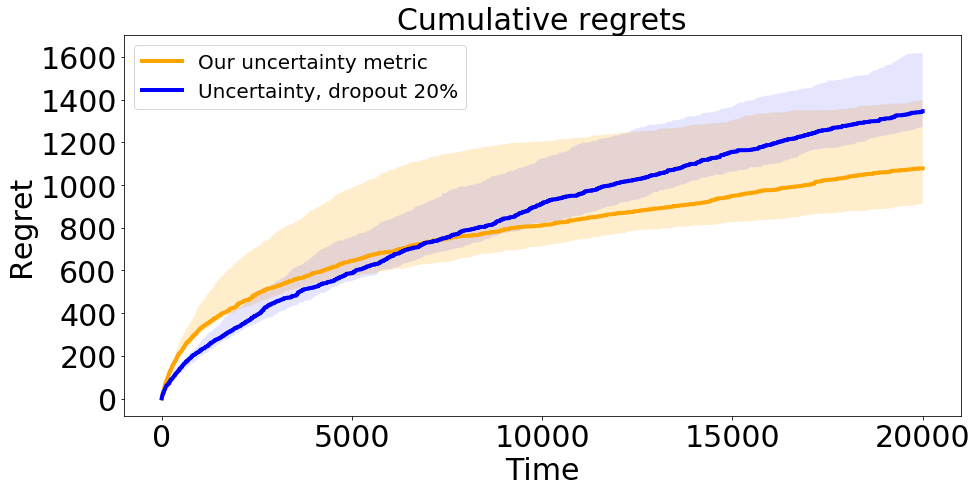

In [5]:

plt.figure(figsize=(15,7))


plt.plot(np.median(results_regret_bandits['two_anchored_10'],0), label="Our uncertainty metric", linewidth=4, color='orange')
plt.fill_between(range(20000), plots['two_anchored_10'][0],
                 plots['two_anchored_10'][1], facecolor='orange', alpha=0.2)


plt.plot(np.median(results_regret_bandits['dropout_20'],0), label="Uncertainty, dropout 20%", linewidth=4, color='blue')
plt.fill_between(range(20000), plots['dropout_20'][0], plots['dropout_20'][1], facecolor='blue', 
                alpha=0.1)


plt.xlabel("Time", fontsize=30)
plt.ylabel("Regret", fontsize=30)
plt.xticks([0, 5000, 10000, 15000, 20000], size=30)
plt.yticks(size=30)
plt.legend(prop={'size': 20}, loc=2)
plt.title('Cumulative regrets', size=30)
plt.show()

## Right

In [5]:
d = defaultdict(LabelEncoder)
USE_CUDA = torch.cuda.is_available()
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)
data_reduced = pd.read_csv("data/data_mushrooms.csv", index_col=0)

#### Parameters

In [6]:
n_features = data_reduced.shape[1] - 1
num_quant = 50
mean_prior = 0
std_prior = .2
lr = 1e-3

batch_size = 32
buffer_size = 10000
num_frames = 600

# # Depending on the model
l2_reg = 1
anchored = True

In [7]:
env = EnvMushroom(data_reduced)

In [8]:
X = env.sample(500)
y = env.y_sample

In [9]:
n_nets = 10
current_models = []
target_models = []
optimizers = []

for i in range(n_nets):
    current_models.append(QRContext(1,
                                    n_features,
                                    num_quant,
                                    mean_prior=mean_prior,
                                    std_prior=std_prior,
                                    l2_reg=l2_reg))
    
    target_models.append(QRContext(1,
                                    n_features,
                                    num_quant,
                                    mean_prior=mean_prior,
                                    std_prior=std_prior,
                                    l2_reg=l2_reg))
    
    optimizers.append(optim.Adam(current_models[-1].parameters(), lr=lr))


In [10]:
reward  = torch.FloatTensor(np.random.normal(y))

In [11]:
for epoch in tqdm(range(200)):
    for i in range(n_nets):
        action     = Variable(torch.LongTensor([0 for j in range(len(X))]))
        
        train_step(current_models[i],
                   target_models[i],
                   optimizers[i],
                   X,
                   action,
                   reward,
                  n_samples=epoch,
                  num_quant=50,
                  anchored=True)

100%|██████████| 200/200 [00:23<00:00,  9.58it/s]


In [12]:
X_test = torch.tensor(X.clone().detach()[np.where(y == 1)]).unsqueeze(0)
dist = [net(X_test.squeeze())[:, 0, :].detach().numpy().mean(0) for net in current_models]

u = []
for i in range(len(current_models)):
    for j in range(i):
        u.append(np.abs(dist[i] - dist[j]))
        
m = []
for i in range(len(current_models)):
    for j in range(i):
        m.append(0.5 * ((dist[i] + dist[j])))

df = pd.DataFrame()
df["ppf"] = np.array(m).mean(0)
df["quantiles value"] = [i/num_quant for i in range(num_quant)]
df["uncertainty"] = np.array(u).mean(0)
df["true_dist"] = df["quantiles value"].apply(lambda x: norm.ppf(x, 1, 1))

/home/bob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


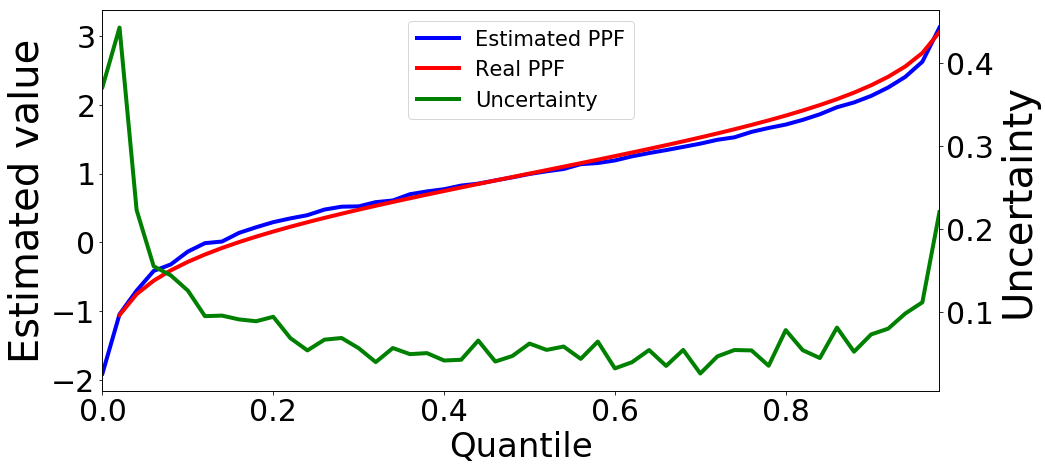

In [13]:
fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()
ax = df.plot("quantiles value", "ppf", ax=ax, legend=False, color=["b"], linewidth=4, label="Estimated PPF")
ax = df.plot("quantiles value", "true_dist", ax=ax, color="red", legend=True, linewidth=4, kind="line", label="Real CDF")
ax2 = df.plot("quantiles value", "uncertainty", ax=ax2, legend=True, color="green", linewidth=4, label = "Uncertainty")
ax.set_xlabel("Quantile", fontsize=34)
ax.set_ylabel("Estimated value", fontsize=40)
ax.tick_params(axis="y", labelsize=30)
ax.tick_params(axis="x", labelsize=30)
ax2.tick_params(axis="y", labelsize=30)
ax2.set_ylabel("Uncertainty", fontsize=40)
# ax.legend(loc=7)
ax.get_legend().remove()
labels = ["Estimated PPF", "Real PPF"]
lines, _ = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc=9, prop={'size': 21})
plt.show()

### Test out of sample

In [14]:
pos = torch.tensor(data_reduced.loc[data_reduced.target == 0].values)[:,1:]
perm = torch.randperm(pos.size(0))
idx = perm[:900]
samples = pos[idx]

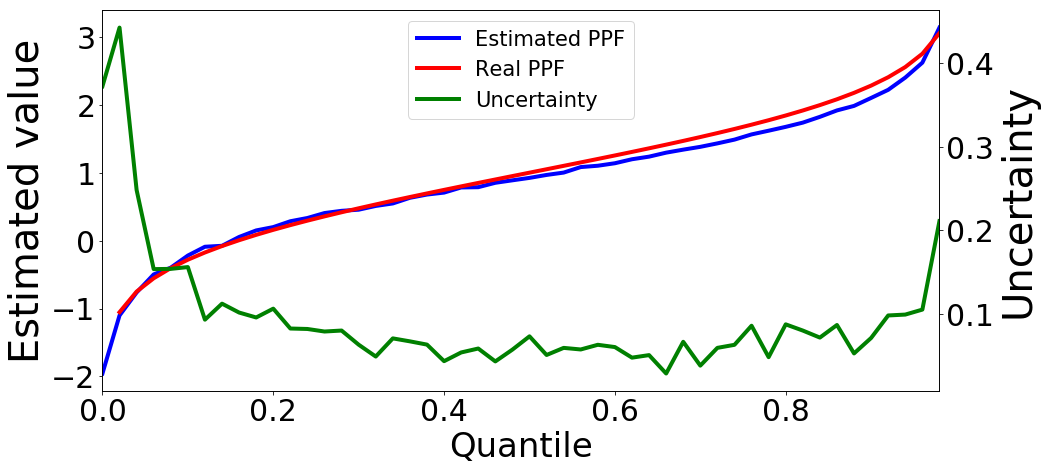

In [15]:
dist_out = [net(samples.squeeze())[:, 0, :].detach().numpy().mean(0) for net in current_models]

u = []
for i in range(len(current_models)):
    for j in range(i):
        u.append(np.abs(dist_out[i] - dist_out[j]))
        
m = []
for i in range(len(current_models)):
    for j in range(i):
        m.append(0.5 * ((dist_out[i] + dist_out[j])))

df2 = pd.DataFrame()
df2["ppf"] = np.array(m).mean(0)
df2["quantiles value"] = [i/num_quant for i in range(num_quant)]
df2["uncertainty"] = np.array(u).mean(0)
df2["true_dist"] = df2["quantiles value"].apply(lambda x: norm.ppf(x, 1, 1))

fig, ax = plt.subplots(figsize=(15, 7))
ax2 = ax.twinx()
ax = df2.plot("quantiles value", "ppf", ax=ax, legend=False, color=["b"], linewidth=4, label="Estimated PPF")
ax = df2.plot("quantiles value", "true_dist", ax=ax, color="red", legend=True, linewidth=4, kind="line", label="Real CDF")
ax2 = df2.plot("quantiles value", "uncertainty", ax=ax2, legend=True, color="green", linewidth=4, label = "Uncertainty")
ax.set_xlabel("Quantile", fontsize=34)
ax.set_ylabel("Estimated value", fontsize=40)
ax.tick_params(axis="y", labelsize=30)
ax.tick_params(axis="x", labelsize=30)
ax2.tick_params(axis="y", labelsize=30)
ax2.set_ylabel("Uncertainty", fontsize=40)
# ax.legend(loc=7)
ax.get_legend().remove()
labels = ["Estimated PPF", "Real PPF"]
lines, _ = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc=9, prop={'size': 21})
plt.show()